# Feature engineering with PySpark - DataCamp
### Notes by César Muro

Feature engineering is the process of using domain knowledge to create new features to help our models perform better.  
* You need to research your data and become your own expert
* Define goals of analysis
* Be curious and ask questions


In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON']= sys.executable
os.environ['PYSPARK_DRIVER_PYTHON']=sys.executable


In [3]:
import findspark
findspark.init()
findspark.find()

'C:\\spark-3.3.2-bin-hadoop2'

In [4]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()

In [5]:
print("PySpark version: "+ spark.version)
print('Python version of Spark Context version :'+spark.sparkContext.pythonVer)
print('The master of Spark Context in the PySpark shell is :'+spark.sparkContext.master)

PySpark version: 3.3.2
Python version of Spark Context version :3.9
The master of Spark Context in the PySpark shell is :local[*]


We will be using parquet files. Parquet data is columnar, meaning that is organized by columns, an important feature for huge datasets.
* They are structured, defined schema.
   - Fields and Data Types defined
   - Great for messy text data
   - spark.read.parque('.parquet')

In [6]:
# The dataset provided is in csv format, so we need to convert it to parquet format
df_csv=spark.read.csv('feature_engineering_with_pyspark/2017_StPaul_MN_Real_Estate.csv',header=True)
df_csv.write.parquet('Real_Estate.parquet', mode='overwrite')
df=spark.read.parquet('Real_Estate.parquet')
print(df.columns)


['No.', 'MLSID', 'StreetNumberNumeric', 'streetaddress', 'STREETNAME', 'PostalCode', 'StateOrProvince', 'City', 'SalesClosePrice', 'LISTDATE', 'LISTPRICE', 'LISTTYPE', 'OriginalListPrice', 'PricePerTSFT', 'FOUNDATIONSIZE', 'FENCE', 'MapLetter', 'LotSizeDimensions', 'SchoolDistrictNumber', 'DAYSONMARKET', 'offmarketdate', 'Fireplaces', 'RoomArea4', 'roomtype', 'ROOF', 'RoomFloor4', 'PotentialShortSale', 'PoolDescription', 'PDOM', 'GarageDescription', 'SQFTABOVEGROUND', 'Taxes', 'RoomFloor1', 'RoomArea1', 'TAXWITHASSESSMENTS', 'TAXYEAR', 'LivingArea', 'UNITNUMBER', 'YEARBUILT', 'ZONING', 'STYLE', 'ACRES', 'CoolingDescription', 'APPLIANCES', 'backonmarketdate', 'ROOMFAMILYCHAR', 'RoomArea3', 'EXTERIOR', 'RoomFloor3', 'RoomFloor2', 'RoomArea2', 'DiningRoomDescription', 'BASEMENT', 'BathsFull', 'BathsHalf', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'Class', 'BATHSTOTAL', 'BATHDESC', 'RoomArea5', 'RoomFloor5', 'RoomArea6', 'RoomFloor6', 'RoomArea7', 'RoomFloor7', 'RoomArea8', 'RoomFloor8', 'Bedroo

**Defining a problem**  
We will define our problem and the context of our data.  
We are going to build a model to predict how much  a house sells for
* Given is listed price and features
  - $X$, independent 'known' variables
* How much to buy the house for
  - $Y$, dependent 'unknown' variable
  - SALESCLOSERPRICE

We need to understand the context and limitations of the data we have:
* We only have a small geographical area, so apply our model to other areas is a serius risks
* We only have residential data, so we should not expect to predict how much a business location is worth
* We only have one year's worth of data which will make it hard to draw strong conclussion about seasonality in this dataset

What types of attributes are avalaible?  
* Dates:  
  - Data lsited
  - Year built  
* Location:  
   - City
   - School District
   - Address
* Size:  
   - number of bedrooms and bathrooms
   - living area  
* Price
   - List price
   - Sales closing price
* Amenities
   - Pool
   - Fireplace
   - Garage
* Construction Materials
    - Siding
    - Roofing

**Validating your data load**
* df.count() for row count
* df.columns a list of columns
* len(df.columns)
  
Checking datatypes:  
* df.dtypes  

What are we predicting?

Which of these fields (or columns) is the value we are trying to predict for?

*    TAXES
*    SALESCLOSEPRICE
*    DAYSONMARKET
*    LISTPRICE


In [6]:
# Select our dependent variable
Y_df = df.select(['SALESCLOSEPRICE'])

# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SALESCLOSEPRICE|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|            100000|
|    max|             99900|
+-------+------------------+



Verifying Data Load

Let's suppose each month you get a new file. You know to expect a certain number of records and columns. In this exercise we will create a function that will validate the file loaded.

*    Create a data validation function check_load() with parameters df a dataframe, num_records as the number of records and num_columns the number of columns.
*    Using num_records create a check to see if the input dataframe df has the same amount with count().
*    Compare input number of columns the input dataframe has withnum_columns by using len() on columns.
*    If both of these return True, then print Validation Passed


In [7]:
def check_load(df, num_records, num_columns):
  # Takes a dataframe and compares record and column counts to input
  # Message to return if the critera below aren't met
  message = 'Validation Failed'
  # Check number of records
  if num_records == df.count():
    # Check number of columns
    if num_columns == len(df.columns):
      # Success message
      message = 'Validation Passed'
  return message

# Print the data validation message
print(check_load(df, 5000, 74))

Validation Passed


Verifying DataTypes

In the age of data we have access to more attributes than we ever had before. To handle all of them we will build a lot of automation but at a minimum requires that their datatypes be correct. In this exercise we will validate a dictionary of attributes and their datatypes to see if they are correct. This dictionary is stored in the variable validation_dict and is available in your workspace.


*    Using df create a list of attribute and datatype tuples with dtypes called actual_dtypes_list.
*    Iterate through actual_dtypes_list, checking if the column names exist in the dictionary of expected dtypes validation_dict.
*    For the keys that exist in the dictionary, check their dtypes and print those that match.


In [8]:
validation_dict= {'ASSESSMENTPENDING': 'string','AssessedValuation': 'double', 'AssociationFee': 'bigint',
'AssumableMortgage': 'string','SQFTBELOWGROUND': 'bigint'}
# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict:

    # Compare attribute types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')

[('No.', 'string'), ('MLSID', 'string'), ('StreetNumberNumeric', 'string'), ('streetaddress', 'string'), ('STREETNAME', 'string'), ('PostalCode', 'string'), ('StateOrProvince', 'string'), ('City', 'string'), ('SalesClosePrice', 'string'), ('LISTDATE', 'string'), ('LISTPRICE', 'string'), ('LISTTYPE', 'string'), ('OriginalListPrice', 'string'), ('PricePerTSFT', 'string'), ('FOUNDATIONSIZE', 'string'), ('FENCE', 'string'), ('MapLetter', 'string'), ('LotSizeDimensions', 'string'), ('SchoolDistrictNumber', 'string'), ('DAYSONMARKET', 'string'), ('offmarketdate', 'string'), ('Fireplaces', 'string'), ('RoomArea4', 'string'), ('roomtype', 'string'), ('ROOF', 'string'), ('RoomFloor4', 'string'), ('PotentialShortSale', 'string'), ('PoolDescription', 'string'), ('PDOM', 'string'), ('GarageDescription', 'string'), ('SQFTABOVEGROUND', 'string'), ('Taxes', 'string'), ('RoomFloor1', 'string'), ('RoomArea1', 'string'), ('TAXWITHASSESSMENTS', 'string'), ('TAXYEAR', 'string'), ('LivingArea', 'string'), 

**Visually Inspecting Data / EDA**  
In the field, you will be tasked with using less than perfect data. This mean, we need to understand its strenghts, weaknesses, and limitations to leverage it effectively.  
* Take a pick on each column to see what thet contain
  - df.describe(['']).show(), df.describe().show()  
* We also have agg methods:  
  - df.agg({'SALESCLOSEPRICE': 'mean'}).collect()  
* Covariance:  
   - df.cov('col_1','col_2')
    
Notes on plotting:  
* Plotting PySpark dataFrames using standard libraries like Seaborn requiere conversion to Pandas.  
* WARNING: Sample PySpark dataFrames before converting to Pandas
* sample(withReplacement, fraction, seed=None) 
* Seaborn distplot 
import seaborn as sns  
sample_df=df.select(['SALESCLOSEPRICE]).sample(FALSE, 0.5,42)  
pandas_df=sample_df.toPandas()  
sns.distplot(pandas_df)
* Seaborn: sns.lmplot(x,y,data)

Using Corr()

The old adage 'Correlation does not imply Causation' is a cautionary tale. However, correlation does give us a good nudge to know where to start looking promising features to use in our models. Use this exercise to get a feel for searching through your data for the first time, trying to find patterns.  
  

*    Use a for loop iterate through the columns.
*    In each loop cycle, compute the correlation between the current column and 'SALESCLOSEPRICE' using the corr() method.
*    Create logic to update the maximum observed correlation and with which column.
*    Print out the name of the column that has the maximum correlation with 'SALESCLOSEPRICE'.


In [9]:
from pyspark.sql.functions import col
columns=['FOUNDATIONSIZE','DAYSONMARKET','FIREPLACES', 'PDOM', 'SQFTABOVEGROUND', 'TAXES', 'TAXWITHASSESSMENTS',
 'TAXYEAR', 'LIVINGAREA', 'YEARBUILT', 'ACRES', 'BACKONMARKETDATE', 'BATHSFULL', 'BATHSHALF', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'BATHSTOTAL',
 'BEDROOMS', 'SQFTBELOWGROUND', 'ASSOCIATIONFEE', 'ASSESSEDVALUATION']

# We need the convert these columns to numeric type
for column in columns:
    df = df.withColumn(column, col(column).cast("double"))


In [10]:
df.show()

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------

In [10]:
df=df.withColumn('SalesClosePrice', df['SALESCLOSEPRICE'].cast("integer"))
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr('SalesClosePrice', col)
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


Using Visualizations: distplot

Understanding the distribution of our dependent variable is very important and can impact the type of model or preprocessing we do. A great way to do this is to plot it, however plotting is not a built in function in PySpark, we will need to take some intermediary steps to make sure it works correctly. In this exercise you will visualize the variable the 'LISTPRICE' variable, and you will gain more insights on its distribution by computing the skewness.

The matplotlib.pyplot and seaborn packages have been imported for you with aliases plt and sns.


*    Sample 50% of the dataframe df with sample() making sure to not use replacement and setting the random seed to 42.
*    Convert the Spark DataFrame to a pandas.DataFrame() with toPandas().
*    Plot a distribution plot using seaborn's distplot() method.
*    Import the skewness() function from pyspark.sql.functions and compute it on the aggregate of the 'LISTPRICE' column with the agg() method. Remember to collect() your result to evaluate the computation.


In [29]:
df.dtypes

[('No.', 'string'),
 ('MLSID', 'string'),
 ('StreetNumberNumeric', 'string'),
 ('streetaddress', 'string'),
 ('STREETNAME', 'string'),
 ('PostalCode', 'string'),
 ('StateOrProvince', 'string'),
 ('City', 'string'),
 ('SalesClosePrice', 'int'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'int'),
 ('LISTTYPE', 'string'),
 ('OriginalListPrice', 'string'),
 ('PricePerTSFT', 'string'),
 ('FOUNDATIONSIZE', 'double'),
 ('FENCE', 'string'),
 ('MapLetter', 'string'),
 ('LotSizeDimensions', 'string'),
 ('SchoolDistrictNumber', 'string'),
 ('DAYSONMARKET', 'double'),
 ('offmarketdate', 'string'),
 ('FIREPLACES', 'double'),
 ('RoomArea4', 'string'),
 ('roomtype', 'string'),
 ('ROOF', 'string'),
 ('RoomFloor4', 'string'),
 ('PotentialShortSale', 'string'),
 ('PoolDescription', 'string'),
 ('PDOM', 'double'),
 ('GarageDescription', 'string'),
 ('SQFTABOVEGROUND', 'double'),
 ('TAXES', 'double'),
 ('RoomFloor1', 'string'),
 ('RoomArea1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'double'

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df=df.withColumn("LISTPRICE",df.LISTPRICE.cast("bigint"))
# Select a single column and sample and convert to pandas
# sample 50% and not use replacement and setting the random seed to 42.
sample_df = df.select(['LISTPRICE']).sample(False, .5, 42)
pandas_df = sample_df.toPandas()


# Queda pendiente esa gráfica
#sns.displot(pandas_df.LISTPRICE)
#plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

[Row(skewness(LISTPRICE)=2.790448093916559)]


Using Visualizations: lmplot

Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process or wrangle them before they can be used.


*    Using the loaded data set df filter it down to the columns 'SALESCLOSEPRICE' and 'LIVINGAREA' with select().
*    Sample 50% of the dataframe with sample() making sure to not use replacement and setting the random seed to 42.
*    Convert the Spark DataFrame to a pandas.DataFrame() with toPandas().
*    Using 'SALESCLOSEPRICE' as your dependent variable and 'LIVINGAREA' as your independent, plot a linear model plot using seaborn lmplot().


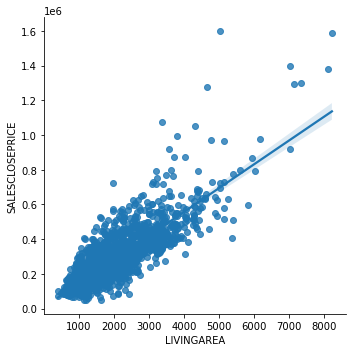

In [12]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()

## Wrangling with Spark Functions


**Dropping data**  
Data can be:
* Recorded worng
* Contain extreme events
* Formatted incorrectly
* Duplications
* Missing  
  
Multiple fields are not needed for our analysis 
* drop(\* cols)  returns a new dataframe that drops the specified
  
Text filtering:  
* where(condition), like(other), ∼ 
* Filter data wo within three standard deviations of the mean
  
std_val=df.agg({'SALESCLOSEPRICE': 'stddev'}).collect()[0][0]  
mean_val=df.agg({'SALESCLOSEPRICE':'mean'}).collect()[0][0]    
hi_bound=mean_val+(3\* std_val)  
low_bound=mean_val-(3\* std_val)  
df=df.where( (df['LISTPRICE'] < hi_bound) & (df['LISTPRICE']>low_bound) ) 

Dropping NAs or NULLs  
DataFrame.dropna()   
* how: any or all. If any, drop a record if it contains any nulls. If all, drop a record only if all its values are null  
* tresh: int, default None if specified, drop records that have less tha thresh non-null values. This overwrites the how parameter.  
* subset: optional list of columns names to consider    

df=df.dropna()  
df=df.dropna(how='all',subset=['LISTPRICE', 'SALESCLOSEPRICE'])  
df=df.dropna(thresh=2)  

Drop duplicates  
* Two or more records contains all the same information
* After dropping columns or joining datasets, check for duplicates 
   
df.dropDuplicates(['streetaddress'])  

Dropping a list of columns

Our data set is rich with a lot of features, but not all are valuable. We have many that are going to be hard to wrangle into anything useful. For now, let's remove any columns that aren't immediately useful by dropping them.  
  

*  'STREETNUMBERNUMERIC': The postal address number on the home
*  'FIREPLACES': Number of Fireplaces in the home
*  'LOTSIZEDIMENSIONS': Free text describing the lot shape
*  'LISTTYPE': Set list of values of sale type
*  'ACRES': Numeric area of lot size



In [13]:
# Show top 30 records
df.show(30)

# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+-

Using text filters to remove records

It pays to have to ask your clients lots of questions and take time to understand your variables. You find out that Assumable mortgage is an unusual occurrence in the real estate industry and your client suggests you exclude them. In this exercise we will use isin() which is similar to like() but allows us to pass a list of values to use as a filter rather than a single one.

In [14]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

# Print count of remaining records
print(df.count())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+

4976


Filtering numeric fields conditionally

Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for. Let's make sure we exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field log_SalesClosePrice.

In [15]:
from pyspark.sql.functions import mean, stddev,log
df=df.withColumn('log_SalesClosePrice',log('SalesClosePrice'))
# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

**Adjusting data**  
'Data does not give up its secrets easily, it must be tortured to confess'  
One common transformation is scaling. MinMax scaling   
$$x^{*}_{i,j}=\frac{x_{i,j}-x_{j}^{min}}{x_{j}^{max}-x_{j}^{min}}$$

Then, in the code:  
max_days=df.agg({'DAYSONMARKET':'max'}).collect()[0][0]  
min_days=df.agg({'DAYSONMARKET:'min'}).collect()[0][0]  
df=df.withColumn("scaled_days",(df['DAYSONMARKET']-min_days)/(max_days-min_days))  
df[['scaled_days']].show()  
  
Another common restriction is that data must closely follow the standard normal distribution. Standardization or z-transforming is the process of shifting and scaling the data to better resemble a normal distribution, which has mean 0 and standard deviation 1.  
We calculate the agg mean and std, and then  
df=df.withColumn('ztrans_days',(df['DAYSONMARKET']-mean_days)/(stddev_days))  
  
One potential way to treat skewed data is to apply a log transformation on the data.  
from pyspark.sql.function import log  
df=df.withColumn('log_SalesClosePrice',log(df['SALECLOSEPRICE']))  

Custom Percentage Scaling

In the slides we showed how to scale the data between 0 and 1. Sometimes you may wish to scale things differently for modeling or display purposes.

In [16]:
from pyspark.sql.functions import round
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET':'max' }).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days', 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


Scaling your scalers

In the previous exercise, we minmax scaled a single variable. Suppose you have a LOT of variables to scale, you don't want hundreds of lines to code for each. Let's expand on the previous exercise and make it a function.

In [17]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df

cols_to_scale=['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|        10.0|0.044444444444444446|
|         4.0|0.017777777777777778|
|        28.0| 0.12444444444444444|
|        19.0| 0.08444444444444445|
|        21.0| 0.09333333333333334|
|        17.0| 0.07555555555555556|
|        32.0| 0.14222222222222222|
|         5.0|0.022222222222222223|
|        23.0| 0.10222222222222223|
|        73.0|  0.3244444444444444|
|        80.0| 0.35555555555555557|
|        79.0|  0.3511111111111111|
|        12.0| 0.05333333333333334|
|         1.0|0.004444444444444...|
|        18.0|                0.08|
|         2.0|0.008888888888888889|
|        12.0| 0.05333333333333334|
|        45.0|                 0.2|
|        31.0| 0.13777777777777778|
|        16.0| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



Correcting Right Skew Data

In the slides we showed how you might use log transforms to fix positively skewed data (data whose distribution is mostly to the left). To correct negative skew (data mostly to the right) you need to take an extra step called "reflecting" before you can apply the inverse of $log$, written as (1/$log$) to make the data look more like normal a normal distribution. Reflecting data uses the following formula to reflect each value: $(x_{max}+1)-x$ .

In [18]:
from pyspark.sql.functions import log
from pyspark.sql.functions import skewness

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


**Working with Missing Data**  
* Missing data is just a completely random subset
* Missing conditionally at random based on another observation
* Data is missing because of how it's collectec
  
When to drop rows with missing data? 
* Missing values are rare
* Missing completely at random  
We can use isNull() function 
* True if the current expression is null  
  
We can use seaborn to visualize missing values by leveraging the heatmap function    
import seaborn as sns    
sub_df=df.select(['ROOMAREA1'])    
sample_df=sample_df.toPandas()    
sns.heatmap(data=pandas_df.isnull())  
 

Imputation of missing values  is the process of replacing missing values.  
Rule base
* Value base on business logic  
Statistics based
* Using mean, median, etc.  
Model based
* Use model to predict value

We can use pyspark function fillna(value, subset=None)  
\# Replacing with the mean value  
col_mean=df.agg({'DAYSONMARKET':'mean'}).collect()[0][0]  
df.fillna(col_mean,subset=['DAYSONMARKET'])

Visualizing Missing Data

Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care lest your model be biased.

Which variable has the most missing values? Run all lines of code except the last one to determine the answer. Once you're confident, and fill out the value and hit "Submit Answer".

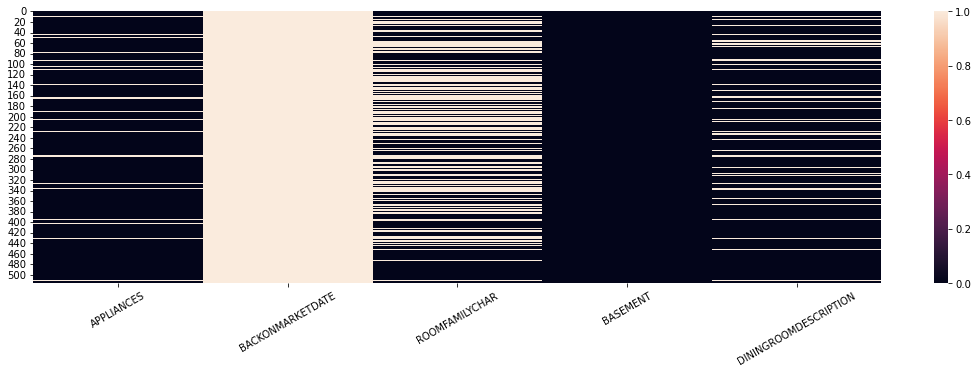

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

columns=['APPLIANCES', 'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'BASEMENT','DININGROOMDESCRIPTION']

# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
fig, ax = plt.subplots(figsize=(19,5))
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

Imputing Missing Data

Missing data happens. If we make the assumption that our data is missing completely at random, we are making the assumption that what data we do have, is a good representation of the population. If we have a few values we could remove them or we could use the mean or median as a replacement. In this exercise, we will look at 'PDOM': Days on Market at Current Price.

In [20]:
# Get a count of the missing values in the column 'PDOM' using where(), isNull() and count().
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[No.: string, MLSID: string, streetaddress: string, STREETNAME: string, PostalCode: string, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: bigint, LISTTYPE: string, OriginalListPrice: string, PricePerTSFT: string, FOUNDATIONSIZE: double, FENCE: string, MapLetter: string, SchoolDistrictNumber: string, DAYSONMARKET: double, offmarketdate: string, FIREPLACES: double, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: double, GarageDescription: string, SQFTABOVEGROUND: double, TAXES: double, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: double, LIVINGAREA: double, UNITNUMBER: string, YEARBUILT: double, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, BACKONMARKETDATE: double, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: s

Missing value replacement is easy, however its ramifications can be huge. Make sure to spend time considering the appropriate ways to handle missing data in your problems.

Calculate Missing Percents

Automation is the future of data science. Learning to automate some of your data preparation pays dividends. In this exercise, we will automate dropping columns if they are missing data beyond a specific threshold.

In [21]:
# We need to change the name of the first column
df=df.withColumnRenamed('No.','NO')

In [22]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
    # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

**Getting more Data**  
The world of Big Data means having access to much more information to include in our analysis. How to connect additional data to our dataset.  
External data is a wonderful way to boost model performance but there are pros and cons to choosing to include it.  
  
A pro is that add important predictor, but a con is that it mat 'bog' analysis down. A pro is taht can supplement/replace values, but it can induce data leakage. A pro is that is easy and cheap to obtain.   
  
Recall the types of join: inner join, full join, left join, and right join. We will use left join.  

PySpark DataFrame joins: 
   
DataFrame.joint(other, on=, how= )  
We can use a condition as on.  

We can also use SparkSQL joins:  
* Apply SQL to your dataframe   

\# Register the dataframe as a temp table
df.createOrReplaceTempVies('df')  
hdf.createOrReplaceTempView('hdf')   
\# Write a SQL statement  
sq_df=spark.sql(""" SELECT * FROM df LEFT JOIN hdf on df.OFFMARKETDATE =hdf.dt  """) 


A Dangerous Join

In this exercise, we will be joining on Latitude and Longitude to bring in another dataset that measures how walk-friendly a neighborhood is. We'll need to be careful to make sure our joining columns are the same data type and ensure we are joining on the same precision (number of digits after the decimal) or our join won't work!

Below you will find that df['latitude'] and df['longitude'] are at a higher precision than walk_df['longitude'] and walk_df['latitude'] we'll need to round them to the same precision so the join will work correctly.

In [ ]:
# Don't execute this chunk, the walk_df is not provided
# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df.longitude.cast('double'))
walk_df = walk_df.withColumn('latitude', walk_df.latitude.cast('double'))

# Round precision
df = df.withColumn('longitude', round(df['longitude'], 5))
df = df.withColumn('latitude', round(df['latitude'], 5))

# Create join condition
condition = [walk_df['latitude'] == df['latitude'], walk_df['longitude'] == df['longitude']]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')
# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())

Spark SQL Join

Sometimes it is much easier to write complex joins in SQL. In this exercise, we will start with the join keys already in the same format and precision but will use SparkSQL to do the joining.

In [ ]:
# Don't execute this chunk, the walk_df is not provided
# Register dataframes as tables
df.createOrReplaceTempView('df')
walk_df.createOrReplaceTempView('walk_df')

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				*
			FROM df
			LEFT JOIN walk_df
			ON df.longitude = walk_df.longitude
			AND df.latitude = walk_df.latitude
			"""
# Perform sql join
joined_df = spark.sql(join_sql)

Checking for Bad Joins

Joins can go bad silently if we are not careful, meaning they will not error out but instead return mangled data with more or less data than you'd intended. Let's take a look at a couple ways that joining incorrectly can change your data set for the worse.

In this example we will look at what happens if you join two dataframes together when the join keys are not the same precision and compare the record counts between the correct join and the incorrect one.

In [ ]:
# Join on mismatched keys precision 
wrong_prec_cond = [df_orig.longitude == walk_df.longitude, df_orig.latitude == walk_df.latitude]
wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
print(correct_join_df.where(correct_join_df['walkscore'].isNull()).count())

# Create a join on too few keys
few_keys_cond = [df.longitude == walk_df.longitude]
few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

# Compare bad join to the correct one
print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
print("Record Count of the Correct Join Example: " + str(correct_join_df.count()))

## Feature Generation  
Why generate new features?  
Combining features together can capture subtle dependent effects between them that impact the putcome variable. These can be represented by multiplying, summing, differencing or dividing two or more variables.  
  
Applying your reasoning and understanding of the problem can help you build powerful predictors   

Differences

Let's explore generating features using existing ones. In the midwest of the U.S. many single family homes have extra land around them for green space. In this example you will create a new feature called 'YARD_SIZE', and then see if the new feature is correlated with our outcome variable.

In [23]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE',- df['FOUNDATIONSIZE'] + df['LOT_SIZE_SQFT'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('SALESCLOSEPRICE', 'YARD_SIZE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('SALESCLOSEPRICE', 'FOUNDATIONSIZE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('SALESCLOSEPRICE', 'LOT_SIZE_SQFT' )))

Corr of ACRES vs SALESCLOSEPRICE: 0.20032633979612804
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.5976957088401494
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.21308192607502127


Ratios

Ratios are all around us. Whether it's miles per gallon or click through rate, they are everywhere. In this exercise, we'll create some ratios by dividing out pairs of columns.

In [24]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0|   139900|             0.0|
|              0.0|   210000|             0.0|
|              0.0|   225000|             0.0|
|              0.0|   230000|             0.0|
|              0.0|   239900|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows

+--------------------+------+---------+
|         TAX_TO_LIST| TAXES|LISTPRICE|
+--------------------+------+---------+
|0.013280914939242315|1858.0|   139900|
| 0.00780952380952381|1640.0|   210000|
|0.010622222222222222|2390.0|   225000|
|0.009330434782608695|2146.0|   230000|
|0.008378491037932471|2010.0|   239900|
+--------------------+------+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|     3.0|       2.0|
|1.

Deeper Features

In previous exercises we showed how combining two features together can create good additional features for a predictive model. In this exercise, you will generate 'deeper' features by combining the effects of three variables into one. Then you will check to see if deeper and more complicated features always make for better predictors.

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               4946|
|   mean| 1.4339460530042523|
| stddev| 14.205761576339642|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



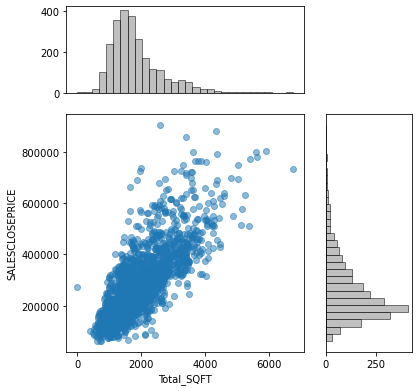

In [25]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTABOVEGROUND'] + df['SQFTBELOWGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

df=df.withColumn('SALESCLOSEPRICE',df['SALESCLOSEPRICE'].cast("integer"))



# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# Linear model plots. No queda con seaborn, no se porque
#sns.jointplot(x=pandas_df['Total_SQFT'],y=pandas_df['SALESCLOSEPRICE'])
#plt.show() 
#Vamos hacerlo con matplotlib

import matplotlib.pyplot as plt
x = pandas_df['Total_SQFT']
y = pandas_df['SALESCLOSEPRICE']

# Crear una figura y dos subplots
fig, ax = plt.subplots(figsize=(6, 6))
ax_histx = fig.add_axes([0.1, 0.7, 0.55, 0.2])
ax_histy = fig.add_axes([0.7, 0.1, 0.2, 0.55])

# Crear el gráfico de dispersión
ax.scatter(x, y, alpha=0.5)

# Agregar los histogramas marginales
ax_histx.hist(x, bins=30, color='gray', alpha=0.5, edgecolor='black')
ax_histy.hist(y, bins=30, color='gray', alpha=0.5, orientation='horizontal', edgecolor='black')

# Ajustar los límites de los ejes para los subplots
ax_histx.set_xlim(ax.get_xlim())
ax_histy.set_ylim(ax.get_ylim())
ax_histx.set_xticks([])
ax_histy.set_yticks([])

# Agregar las etiquetas de los ejes y el título
ax.set_xlabel('Total_SQFT')
ax.set_ylabel('SALESCLOSEPRICE')
#fig.suptitle('Joint Plot', fontsize=14)

# Ajustar el espaciado entre los subplots utilizando la función `plt.subplots_adjust()`
plt.subplots_adjust(left=0.10, bottom=0.10, right=0.65, top=0.65, wspace=0.35, hspace=0.15)

# Mostrar la gráfica
plt.show()

Using the describe() function you could have seen there was a max of 1000 bathrooms per 1000sqft, which is almost for sure an issue with our data since no sane person would need a bathroom for square foot! If you really wanted to use this feature you'd have to filter that outlier out or overwrite it to NULL with when(). After plotting the jointplots()s you should have seen that the less complicated feature Total_SQFT had a much better R**2 of .67 vs BATHS_PER_1000SQFT's .02'. Often simplier is better!

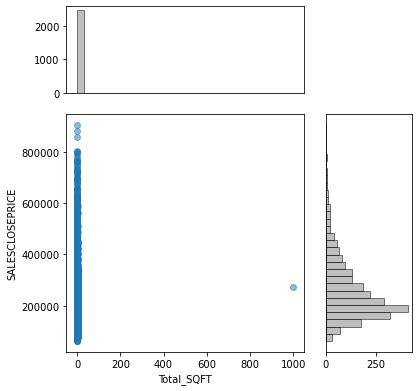

In [81]:
# No queda con seaborn, no se xq
#sns.jointplot(x=pandas_df['BATHS_PER_1000SQFT'],y=pandas_df['SALESCLOSEPRICE'])
#plt.show()

#Vamos hacerlo con matplot lib
import matplotlib.pyplot as plt
import numpy as np


x = pandas_df['BATHS_PER_1000SQFT']
y = pandas_df['SALESCLOSEPRICE']

# Crear una figura y dos subplots
fig, ax = plt.subplots(figsize=(6, 6))
ax_histx = fig.add_axes([0.1, 0.7, 0.55, 0.2])
ax_histy = fig.add_axes([0.7, 0.1, 0.2, 0.55])

# Crear el gráfico de dispersión
ax.scatter(x, y, alpha=0.5)

# Agregar los histogramas marginales
ax_histx.hist(x, bins=30, color='gray', alpha=0.5, edgecolor='black')
ax_histy.hist(y, bins=30, color='gray', alpha=0.5, orientation='horizontal', edgecolor='black')

# Ajustar los límites de los ejes para los subplots
ax_histx.set_xlim(ax.get_xlim())
ax_histy.set_ylim(ax.get_ylim())
ax_histx.set_xticks([])
ax_histy.set_yticks([])

# Agregar las etiquetas de los ejes y el título
ax.set_xlabel('Total_SQFT')
ax.set_ylabel('SALESCLOSEPRICE')

# Ajustar el espaciado entre los subplots utilizando la función `plt.subplots_adjust()`
plt.subplots_adjust(left=0.10, bottom=0.10, right=0.65, top=0.65, wspace=0.35, hspace=0.15)

# Mostrar la gráfica
plt.show()

**Time features**  
Things repeat. Building the right time features is important.  
To work with dates we need them to be of Spark data type.  
from pyspark.sql.functions import to_date  
  
\# Cast the data type to Date  
df=df.withColumn('LISTDATE', to_date('LISTDATE')).  
  
With our data typed correctly, we can use build-ins to get various time components.  

\# Create a new column of month number  
df=df.withColumn('LIST_MONTH',month('LISTDATE'))  
\#  Create new columns of the day number within the month  
df=df.withColumn('LIST_DAYMONTH', dayofmonth('LISTDATE'))  


Basic Time Based Metrics:  
from pyspark.sql.function import datediff  
df.withColumn('DAYSONMARKET',datediff('OFFMARKETDATE','LISTDATE'))  
  
Lagging features. To create a lagged feature we will need a few new functions.  
Window() returns a record based off a group of records. 
lag(col, count=1) returns the value that is offset by rows before the current row  
  
Time Components

Being able to work with time components for building features is important but you can also use them to explore and understand your data further. In this exercise, you'll be looking to see if there is a pattern to which day of the week a house lists on. Please keep in mind that PySpark's week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.  



In [58]:
df.show()

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+---------+------------------+--------------------+-----+------------------+--------------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+--------+---------------+--------------+-----------------+-----------------+-------------------+----------------------+---------------------+----------------

In [ ]:
#from pyspark.sql import functions as F
#df_pr = spark.createDataFrame(
#    [('x', '01/31/2021', '12/31/2020'),
#     ('y', '1/1/2020', '1/18/2020'),
#     ('z', '15-01-2020', '20-10-2020')],
#    ['id', 'c1', 'c2'])

#for c in ['c1', 'c2']:
#    df_pr = df_pr.withColumn(
#        c, 
#        F.when(F.col(c).rlike('\d{1,2}/\d{1,2}/\d{4}'), F.to_date(c, 'M/d/yyyy'))
#         .when(F.col(c).rlike('\d{1,2}-\d{1,2}-\d{4}'), F.to_date(c, 'd-M-yyyy'))
#    )

In [26]:
import pyspark.sql.functions as F

# Convert to date type
df_d = df.withColumn('LISTDATE', F.regexp_replace("LISTDATE"," 0:00","") )

df_d = df_d.withColumn('LISTDATE', F.when(F.col('LISTDATE').rlike('\d{1,2}/\d{1,2}/\d{4}'), F.to_date('LISTDATE', 'M/d/yyyy')))


# Get the day of the week
df_d = df_d.withColumn('List_Day_of_Week', F.dayofweek('LISTDATE'))



In [27]:
df=df_d

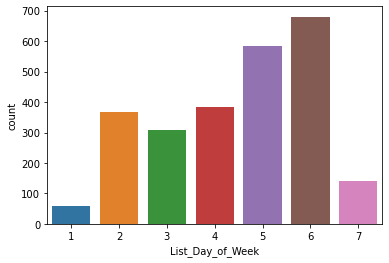

In [28]:
# Sample and convert to pandas dataframe
sample_df = df_d.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

Joining On Time Components

Often times you will use date components to join in other sets of information. However, in this example, we need to use data that would have been available to those considering buying a house. This means we will need to use the previous year's reporting data for our analysis.

In [29]:
import pyspark.sql.functions as F
price_df=spark.read.csv('C:/Users/cmuro/feature_engineering_with_pyspark/price_data.csv',header=True)
# Create year column
from pyspark.sql.functions import year

# Create year column
df_p = df.withColumn('list_year', year(df['LISTDATE']))

# Adjust year to match
df_p = df_p.withColumn('report_year', (df_p['list_year'] - 1))

# Create join condition
condition = [df_p['CITY'] == price_df['City'], df_p['report_year'] == price_df['year']]

# Join the dataframes together
df_p = df_p.join(price_df, on=condition, how='left')
# Inspect that new columns are available
df_p[['MedianHomeValue']].show()



+---------------+
|MedianHomeValue|
+---------------+
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
+---------------+
only showing top 20 rows



Date Math

In this example, we'll look at verifying the frequency of our data. The Mortgage dataset is supposed to have weekly data but let's make sure by lagging the report date and then taking the difference of the dates.

Recall that to create a lagged feature we will need to create a window(). window() allows you to return a value for each record based off some calculation against a group of records, in this case, the previous period's mortgage rate.

In [ ]:
# Don't execute this chunk, the data mort_df is not provided and is too large to write
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

# Cast data type
mort_df = mort_df.withColumn('DATE', to_date(mort_df['DATE']))

# Create window
w = Window().orderBy(mort_df['DATE'])
# Create lag column
mort_df = mort_df.withColumn('DATE-1', lag(mort_df['DATE'], count=1).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', datediff(mort_df['DATE'], mort_df['DATE-1']))
# Print results
mort_df.select('Days_Between_Report').distinct().show()

**Extracting features**    
Extracting age with text match.  
from pyspark.sql.functions import when  
find_under_8=df['ROOF'].like('%Age 8 years or Less%')    
find_over_8=df['ROOF'].like('%Age Over 8 Years%')  

\# Apply filters using when() and otherwise    
df=df.withColumn('old_roof', ( when(find_over_8,1, 1),when(find_over_8,0).otherwise(None) )  )      
  
Splitting columns  
from pyspark.sql.function import split  
\# Split the column on commas into a list  
split_col = split(df['ROOF'], ',')  
\# Put the first value of the list into a new column  
df=df.withColumn('Roof_Material', split_col.getItem(0))   
  
   

Explode & Pivot !    

from pyspark.sql.functions import split, explode, lit, coalesce, first  
\# split the column on commas into a list  
df=df.withColumn('roof_list',split(['ROOF'], ',' ))  
  
\# Explode list into new records for each value  
ex_df=df.withColumn('ex_roof_list', explode(df['roof_list']) )  

\# Create a dummy column of constant value  
ex_df= ex_df.withColumn('constant_val', lit(1) )     

\# Pivot the values into boolean columns     
piv_df=ex_df.groupBy('NO').pivot('ex_roof_list').agg(coalesce(first('constant_val')))

In [30]:
# Import needed functions
from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = df_p['GARAGEDESCRIPTION'].like('%Attached%')
has_detached_garage = df_p['GARAGEDESCRIPTION'].like('%Detached%')

# Conditional value assignment 
df_p = df_p.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df_p[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+------------------------------------------------------------------+-------------------+
|                                                 GARAGEDESCRIPTION|has_attached_garage|
+------------------------------------------------------------------+-------------------+
|                                                   Attached Garage|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|    Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                               Attached Garage, Driveway - Asphalt|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|                    

Splitting & Exploding

Being able to take a compound field like GARAGEDESCRIPTION and massaging it into something useful is an involved process. It's helpful to understand early what value you might gain out of expanding it. In this example, we will convert our string to a list-like array, explode it and then inspect the unique values.

In [31]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df_p = df_p.withColumn('garage_list', split(df_p['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df_p.withColumn('ex_garage_list', explode(df_p['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(100, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
|                  Units Vary|
|                    Assigned|
|                   Tuckunder|
|                     Covered|
|            Insulated Garage|
|         Driveway - Concrete|
|                      Tandem|
|           Driveway - Shared|
+----------------------------+



Pivot & Join

Being able to explode and pivot a compound field is great, but you are left with a dataframe of only those pivoted values. To really be valuable you'll need to rejoin it to the original dataset! After joining the datasets we will have a lot of NULL values for the newly created columns since we know the context of how they were created we can safely fill them in with zero as either the new has an attribute or it doesn't.

In [ ]:
from pyspark.sql.functions import coalesce, first

# Pivot 
piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_value')))

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

**Binarizing, Bucketing & Encoding**   
   
Binarizing is a helpful way to collapse some nunace in your model to just a yes/no. Binarization takes values below or equal to a threshold and replaces them by 0 values above it by 1. After importing Binarizer, we need to make sure the column we want to apply it to is of type double.  
  
from pyspark.ml.feature import Binarizer  
df=df.withColumn('FIREPLACES',df['FIREPLACES'].cast('double')) 
bin=Binarizer(threshold=0.0, inputCol='FIREPLACES', outputCol='FireplaceT')  
df = bin.transform(df)   
    
Bucketing:  
Also called binning, is a way to create ordinal variables.  

\# Define how to split data
splits = [0,1,2,3,4, float('Inf')]   

\# Create bucketing transformer  
buck = Bucketizer(splits=splits, inputCol='BATHSTOTAL', outputCol='baths')  
df=buck.transform(df)      
  
One Hot Encoding, where you pivot each categorical value into a True/False column of its own. Keep in mind for columns with a lot of different values this can create potentially hundreds or thousands of new columns!:  
  
from pyspark.ml.feature import OneHotEncoder, StringIndexer  
stringIndexer = StringIndexer(inputCol = 'CITY', outputCol= 'City_Index')  
model= stringIndexer.fit(df)  
indexed= model.transform(df)      
  
One Hot Encoding the PySpark Way:  
encoder= OneHotEncoder(inputCol='City_Index', outputCol='City_Vec')  
encoded_df = encoder.transform(indexed)  
encoded_df[['City_Vec']].show(4)  


Binarizing Day of Week

In a previous video, we saw that it was very unlikely for a home to list on the weekend. Let's create a new field that says if the house is listed for sale on a weekday or not. In this example there is a field called List_Day_of_Week that has Monday is labeled 1.0 and Sunday is 7.0. Let's convert this to a binary field with weekday being 0 and weekend being 1. We can use the pyspark feature transformer Binarizer to do this.

In [81]:
df = df_p.withColumn('List_Day_of_Week', df_p['List_Day_of_Week'].cast('double'))

In [82]:
# Import transformer
from pyspark.ml.feature import Binarizer

# Create the transformer
binarizer = Binarizer(threshold=5, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week', 'Listed_On_Weekend']].show()

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             7.0|              1.0|
|             2.0|              0.0|
|             2.0|              0.0|
|             6.0|              1.0|
|             3.0|              0.0|
|             2.0|              0.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             5.0|              0.0|
|             7.0|              1.0|
|             6.0|              1.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             2.0|              0.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             1.0|              0.0|
|             6.0|              1.0|
|             7.0|              1.0|
|             6.0|              1.0|
+----------------+-----------------+
only showing top 20 rows



Bucketing

If you are a homeowner its very important if a house has 1, 2, 3 or 4 bedrooms. But like bathrooms, once you hit a certain point you don't really care whether the house has 7 or 8. This example we'll look at how to figure out where are some good value points to bucket.

In [49]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NO                      2523 non-null   object 
 1   MLSID                   2523 non-null   object 
 2   streetaddress           2523 non-null   object 
 3   STREETNAME              2523 non-null   object 
 4   PostalCode              2523 non-null   object 
 5   StateOrProvince         2523 non-null   object 
 6   City                    2523 non-null   object 
 7   SALESCLOSEPRICE         2523 non-null   int32  
 8   LISTDATE                2523 non-null   object 
 9   LISTPRICE               2523 non-null   int64  
 10  LISTTYPE                2523 non-null   object 
 11  OriginalListPrice       2523 non-null   object 
 12  PricePerTSFT            2523 non-null   object 
 13  FOUNDATIONSIZE          2523 non-null   float64
 14  FENCE                   1488 non-null   

In [83]:
from pyspark.ml.feature import Bucketizer


# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BEDROOMS', outputCol='bedrooms')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['BEDROOMS', 'bedrooms']].show()

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     3.0|     3.0|
|     4.0|     4.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
+--------+--------+
only showing top 20 rows



c:\Users\cmuro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

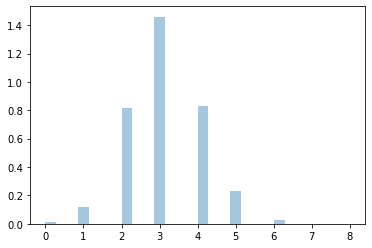

In [43]:
# Plot distribution of sample_df
bedrooms_sample=sample_df['BEDROOMS']
sns.distplot(bedrooms_sample, axlabel='BEDROOMS')
plt.show()

One Hot Encoding

In the United States where you live determines which schools your kids can attend. Therefore it's understandable that many people care deeply about which school districts their future home will be in. While the school districts are numbered in SCHOOLDISTRICTNUMBER they are really categorical. Meaning that summing or averaging these values has no apparent meaning. Therefore in this example we will convert SCHOOLDISTRICTNUMBER from a categorial variable into a numeric vector to use in our machine learning model later.

In [84]:
df.select(['SchoolDistrictNumber']).show()

+--------------------+
|SchoolDistrictNumber|
+--------------------+
|    834 - Stillwater|
|    834 - Stillwater|
|622 - North St Pa...|
|    834 - Stillwater|
|622 - North St Pa...|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
|    834 - Stillwater|
+--------------------+
only showing top 20 rows



In [86]:
df.show()

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+----------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+---------+------------------+--------------------+-----+------------------+--------------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+--------+---------------+--------------+-----------------+-----------------+-------------------+----------------------+---------------------+--------------------+

In [77]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SchoolDistrictNumber', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.fit(indexed_df).transform(indexed_df)


In [78]:
# Inspect the transformation steps
encoded_df[['SchoolDistrictNumber', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SchoolDistrictNumber|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0]

## Building the model  


As we going to predict a quantity, we take the Regression archetype, whic predicts continuos values.  
  
PySpark regression models:  
* Methods in ml.regression:  
   - GeneralizedLinearRegression
   - IsotonicRegression
   - LinearRegression
   - DecisionTreeRegression
   - GBTRegression
   - RandomForestRegression  
  
 Test and Train Splits for Time Series:  
 Doing incremental testing is called step-forward optimization.  
 max_date=df.agg({'OFFMKDATE': 'max'}).collect()[0][0]  
 min_date=df.agg({'OFFMKDATE': 'min'}).collect()[0][0]  
 \# Find how many days our data spans  
 from pyspark.sqlfunctions import datediff  
 range_in_days= datediff(max_date, min_date)  
   
 \# Find the date to split the dataset on  
 from pyspark.sql.function import date_add  
 split_in_days= round(range_in_day*0.8)  
 split_date= date_add(min_date, split_in_days)  

 \# Split the data  
 train_df = df.where(df['OFFMKTDATE'] < splt_date>)  
 test_data=df.where(df['OFFMKDATE'] >= split_date ).where(df['LISTDATE'] >= splt_date )        





Creating Time Splits

In the video, we learned why splitting data randomly can be dangerous for time series as data from the future can cause overfitting in our model. Often with time series, you acquire new data as it is made available and you will want to retrain your model using the newest data. In the video, we showed how to do a percentage split for test and training sets but suppose you wish to train on all available data except for the last 45days which you want to use for a test set.

In this exercise, we will create a function to find the split date for using the last 45 days of data for testing and the rest for training. Please note that timedelta() has already been imported for you from the standard python library datetime.

In [87]:
import pyspark.sql.functions as F

# Convert to date type
df_d = df.withColumn('offmarketdate', F.regexp_replace("offmarketdate"," 0:00","") )

df_d = df_d.withColumn('offmarketdate', F.when(F.col('offmarketdate').rlike('\d{1,2}/\d{1,2}/\d{4}'), F.to_date('offmarketdate', 'M/d/yyyy')))


# Get the day of the week
#df_d = df_d.withColumn('List_Day_of_Week', F.dayofweek('LISTDATE'))

In [90]:
df=df_d

In [92]:
from datetime import timedelta
def train_test_split_date(df, split_col, test_days=45):
    """Calculate the date to split test and training sets"""
    # Find how many days our data spans
    max_date = df.agg({split_col: 'max'}).collect()[0][0]
    min_date = df.agg({split_col: 'min'}).collect()[0][0]
    # Subtract an integer number of days from the last date in dataset
    split_date = max_date - timedelta(days=test_days)
    return split_date

# Find the date to use in spitting test and train
split_date = train_test_split_date(df, 'offmarketdate')


In [93]:
# Create Sequential Test and Training Sets
train_df = df.where(df['offmarketdate'] < split_date) 
test_df = df.where(df['offmarketdate'] >= split_date).where(df['LISTDATE'] <= split_date) 

In [94]:
train_df.show()

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+----------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+------------+-------------+----------+---------+--------------------+--------------------+----------+------------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+---------+------------------+--------------------+-----+------------------+--------------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+--------+---------------+--------------+-----------------+-----------------+-------------------+----------------------+---------------------+--------------------+--

Adjusting Time Features

We have mentioned throughout this course some of the dangers of leaking information to your model during training. Data leakage will cause your model to have very optimistic metrics for accuracy but once real data is run through it the results are often very disappointing.

In this exercise, we are going to ensure that DAYSONMARKET only reflects what information we have at the time of predicting the value. I.e., if the house is still on the market, we don't know how many more days it will stay on the market. We need to adjust our test_df to reflect what information we currently have as of 2017-12-10.

NOTE: This example will use the lit() function. This function is used to allow single values where an entire column is expected in a function call.

In [96]:
from pyspark.sql.functions import datediff, to_date, lit

split_date = to_date(lit('2017-12-10'))

# Create a copy of DAYSONMARKET to review later
test_df = test_df.withColumn('DAYSONMARKET_Original', test_df['DAYSONMARKET'])

# Recalculate DAYSONMARKET from what we know on our split date
test_df = test_df.withColumn('DAYSONMARKET', datediff(split_date, test_df['LISTDATE']))

# Review the difference
test_df[['LISTDATE', 'offmarketdate', 'DAYSONMARKET_Original', 'DAYSONMARKET']].show()


+----------+-------------+---------------------+------------+
|  LISTDATE|offmarketdate|DAYSONMARKET_Original|DAYSONMARKET|
+----------+-------------+---------------------+------------+
|2017-10-06|   2018-01-24|                110.0|          65|
|2017-09-18|   2017-12-12|                 82.0|          83|
|2017-11-07|   2017-12-12|                 35.0|          33|
|2017-10-30|   2017-12-11|                 42.0|          41|
|2017-07-14|   2017-12-19|                158.0|         149|
|2017-10-25|   2017-12-20|                 45.0|          46|
|2017-12-07|   2017-12-23|                 16.0|           3|
|2017-11-22|   2017-12-16|                 24.0|          18|
|2017-10-27|   2017-12-13|                 47.0|          44|
|2017-09-29|   2017-12-12|                 12.0|          72|
|2017-11-28|   2017-12-11|                 13.0|          12|
|2017-09-09|   2018-01-17|                119.0|          92|
|2017-11-18|   2017-12-15|                 26.0|          22|
|2017-12

**Feature Engineering Assumptions for Random Forest Regression**  
Random Forest Regression:  
* Skewed/Non normal data? Ok  
* Unscaled? Ok  
* Missin data? Ok  
  
PySpark ML algorithms require all of the type of the features to be provided in a single column of type vector. To do this we need to import the VectorAssembler transformer to use it later. Sadly, while Random Forest Regression can handle missing values, vectors cannot. Due to the nature of how tree-based machine learning partitions data, we can just assign missings a value that is outside the existing range of the variable to replace nulls with.  
  
df=df.fillna(-1)      
vec= VertorAssemble(inputCols=feature_cols, outputCol='features')  
df= vec.transform(df)
ml_already_df=df.select(['SALECLOSEPRICE','features'])  
m-_ready_df.show()  

Missing values are handled by Random Forests internally where they partition on missing values. As long as you replace them with something outside of the range of normal values, they will be handled correctly. Likewise, categorical features only need to be mapped to numbers, they are fine to stay all in one column by using a StringIndexer as we saw in chapter 3. OneHot encoding which converts each possible value to its own boolean feature is not needed.

Dropping Columns with Low Observations

After doing a lot of feature engineering it's a good idea to take a step back and look at what you've created. If you've used some automation techniques on your categorical features like exploding or OneHot Encoding you may find that you now have hundreds of new binary features. While the subject of feature selection is material for a whole other course but there are some quick steps you can take to reduce the dimensionality of your data set.  
  
In this exercise, we are going to remove columns that have less than 30 observations. 30 is a common minimum number of observations for statistical significance. Any less than that and the relationships cause overfitting because of a sheer coincidence!  

In [99]:
binary_cols= ['FENCE','FENCE_ELECTRIC', 'FENCE_NAN', 'FENCE_PARTIAL', 'FENCE_RAIL', 'FENCE_OTHER', 'FENCE_CHAIN LINK', 'FENCE_FULL', 'FENCE_NONE', 'FENCE_PRIVACY',
 'FENCE_WOOD', 'FENCE_INVISIBLE','ROOF_ASPHALT SHINGLES', 'ROOF_SHAKES', 'ROOF_NAN', 'ROOF_UNSPECIFIED SHINGLE', 'ROOF_SLATE', 'ROOF_PITCHED', 'ROOF_FLAT', 'ROOF_TAR/GRAVEL',
 'ROOF_OTHER', 'ROOF_METAL', 'ROOF_TILE', 'ROOF_RUBBER', 'ROOF_WOOD SHINGLES', 'ROOF_AGE OVER 8 YEARS', 'ROOF_AGE 8 YEARS OR LESS', 'POOLDESCRIPTION_NAN', 'POOLDESCRIPTION_HEATED',
 'POOLDESCRIPTION_NONE', 'POOLDESCRIPTION_SHARED', 'POOLDESCRIPTION_INDOOR', 'POOLDESCRIPTION_OUTDOOR', 'POOLDESCRIPTION_ABOVE GROUND', 'POOLDESCRIPTION_BELOW GROUND', 'GARAGEDESCRIPTION_ASSIGNED',
 'GARAGEDESCRIPTION_TANDEM', 'GARAGEDESCRIPTION_UNCOVERED/OPEN', 'GARAGEDESCRIPTION_TUCKUNDER', 'GARAGEDESCRIPTION_DRIVEWAY - ASPHALT', 'GARAGEDESCRIPTION_HEATED GARAGE', 'GARAGEDESCRIPTION_UNDERGROUND GARAGE',
 'GARAGEDESCRIPTION_DRIVEWAY - SHARED', 'GARAGEDESCRIPTION_CONTRACT PKG REQUIRED', 'GARAGEDESCRIPTION_GARAGE DOOR OPENER', 'GARAGEDESCRIPTION_MORE PARKING OFFSITE FOR FEE', 'GARAGEDESCRIPTION_VALET PARKING FOR FEE', 'GARAGEDESCRIPTION_OTHER',
 'GARAGEDESCRIPTION_MORE PARKING ONSITE FOR FEE', 'GARAGEDESCRIPTION_DRIVEWAY - OTHER SURFACE', 'GARAGEDESCRIPTION_DETACHED GARAGE', 'GARAGEDESCRIPTION_SECURED',
 'GARAGEDESCRIPTION_CARPORT', 'GARAGEDESCRIPTION_DRIVEWAY - CONCRETE', 'GARAGEDESCRIPTION_ON-STREET PARKING ONLY', 'GARAGEDESCRIPTION_COVERED', 'GARAGEDESCRIPTION_INSULATED GARAGE',
 'GARAGEDESCRIPTION_UNASSIGNED', 'GARAGEDESCRIPTION_NONE', 'GARAGEDESCRIPTION_DRIVEWAY - GRAVEL', 'GARAGEDESCRIPTION_NO INT ACCESS TO DWELLING', 'GARAGEDESCRIPTION_UNITS VARY',
 'GARAGEDESCRIPTION_ATTACHED GARAGE', 'APPLIANCES_NAN', 'APPLIANCES_COOKTOP', 'APPLIANCES_WALL OVEN', 'APPLIANCES_WATER SOFTENER - OWNED', 'APPLIANCES_DISPOSAL', 'APPLIANCES_DISHWASHER',
 'APPLIANCES_OTHER', 'APPLIANCES_INDOOR GRILL', 'APPLIANCES_WASHER', 'APPLIANCES_RANGE', 'APPLIANCES_REFRIGERATOR', 'APPLIANCES_FURNACE HUMIDIFIER', 'APPLIANCES_TANKLESS WATER  HEATER',
 'APPLIANCES_ELECTRONIC AIR FILTER', 'APPLIANCES_MICROWAVE', 'APPLIANCES_EXHAUST FAN/HOOD', 'APPLIANCES_NONE', 'APPLIANCES_CENTRAL VACUUM', 'APPLIANCES_TRASH COMPACTOR', 'APPLIANCES_AIR-TO-AIR EXCHANGER',
 'APPLIANCES_DRYER', 'APPLIANCES_FREEZER', 'APPLIANCES_WATER SOFTENER - RENTED', 'EXTERIOR_SHAKES', 'EXTERIOR_CEMENT BOARD', 'EXTERIOR_BLOCK', 'EXTERIOR_VINYL', 'EXTERIOR_FIBER BOARD',
 'EXTERIOR_OTHER', 'EXTERIOR_METAL', 'EXTERIOR_BRICK/STONE', 'EXTERIOR_STUCCO', 'EXTERIOR_ENGINEERED WOOD', 'EXTERIOR_WOOD', 'DININGROOMDESCRIPTION_EAT IN KITCHEN', 'DININGROOMDESCRIPTION_NAN',
 'DININGROOMDESCRIPTION_OTHER', 'DININGROOMDESCRIPTION_LIVING/DINING ROOM', 'DININGROOMDESCRIPTION_SEPARATE/FORMAL DINING ROOM', 'DININGROOMDESCRIPTION_KITCHEN/DINING ROOM', 'DININGROOMDESCRIPTION_INFORMAL DINING ROOM',
 'DININGROOMDESCRIPTION_BREAKFAST AREA', 'BASEMENT_FINISHED (LIVABLE)', 'BASEMENT_PARTIAL', 'BASEMENT_SUMP PUMP', 'BASEMENT_INSULATING CONCRETE FORMS', 'BASEMENT_CRAWL SPACE', 'BASEMENT_PARTIAL FINISHED', 'BASEMENT_CONCRETE BLOCK',
 'BASEMENT_DRAINAGE SYSTEM', 'BASEMENT_POURED CONCRETE', 'BASEMENT_UNFINISHED', 'BASEMENT_DRAIN TILED', 'BASEMENT_WOOD', 'BASEMENT_FULL', 'BASEMENT_EGRESS WINDOWS', 'BASEMENT_DAY/LOOKOUT WINDOWS', 'BASEMENT_SLAB',
 'BASEMENT_STONE', 'BASEMENT_NONE', 'BASEMENT_WALKOUT', 'BATHDESC_MAIN FLOOR 1/2 BATH', 'BATHDESC_TWO MASTER BATHS', 'BATHDESC_MASTER WALK-THRU', 'BATHDESC_WHIRLPOOL', 'BATHDESC_NAN',
 'BATHDESC_3/4 BASEMENT', 'BATHDESC_TWO BASEMENT BATHS', 'BATHDESC_OTHER', 'BATHDESC_3/4 MASTER', 'BATHDESC_MAIN FLOOR 3/4 BATH', 'BATHDESC_FULL MASTER', 'BATHDESC_MAIN FLOOR FULL BATH', 'BATHDESC_WALK-IN SHOWER',
 'BATHDESC_SEPARATE TUB & SHOWER', 'BATHDESC_FULL BASEMENT', 'BATHDESC_BASEMENT', 'BATHDESC_WALK THRU', 'BATHDESC_BATHROOM ENSUITE', 'BATHDESC_PRIVATE MASTER', 'BATHDESC_JACK & JILL 3/4', 'BATHDESC_UPPER LEVEL 1/2 BATH',
 'BATHDESC_ROUGH IN', 'BATHDESC_UPPER LEVEL FULL BATH', 'BATHDESC_1/2 MASTER', 'BATHDESC_1/2 BASEMENT', 'BATHDESC_JACK AND JILL', 'BATHDESC_UPPER LEVEL 3/4 BATH', 'ZONING_INDUSTRIAL',
 'ZONING_BUSINESS/COMMERCIAL', 'ZONING_OTHER', 'ZONING_RESIDENTIAL-SINGLE', 'ZONING_RESIDENTIAL-MULTI-FAMILY', 'COOLINGDESCRIPTION_WINDOW', 'COOLINGDESCRIPTION_WALL', 'COOLINGDESCRIPTION_DUCTLESS MINI-SPLIT',
 'COOLINGDESCRIPTION_NONE', 'COOLINGDESCRIPTION_GEOTHERMAL', 'COOLINGDESCRIPTION_CENTRAL', 'CITY:LELM - LAKE ELMO', 'CITY:MAPW - MAPLEWOOD', 'CITY:OAKD - OAKDALE', 'CITY:STP - SAINT PAUL', 'CITY:WB - WOODBURY',
 'LISTTYPE:EXCLUSIVE AGENCY', 'LISTTYPE:EXCLUSIVE RIGHT', 'LISTTYPE:EXCLUSIVE RIGHT WITH EXCLUSIONS', 'LISTTYPE:OTHER', 'LISTTYPE:SERVICE AGREEMENT', 'SCHOOLDISTRICTNUMBER:6 - SOUTH ST. PAUL', 'SCHOOLDISTRICTNUMBER:622 - NORTH ST PAUL-MAPLEWOOD',
 'SCHOOLDISTRICTNUMBER:623 - ROSEVILLE', 'SCHOOLDISTRICTNUMBER:624 - WHITE BEAR LAKE', 'SCHOOLDISTRICTNUMBER:625 - ST. PAUL', 'SCHOOLDISTRICTNUMBER:832 - MAHTOMEDI', 'SCHOOLDISTRICTNUMBER:833 - SOUTH WASHINGTON COUNTY', 'SCHOOLDISTRICTNUMBER:834 - STILLWATER',
 'POTENTIALSHORTSALE:NO', 'POTENTIALSHORTSALE:NOT DISCLOSED', 'STYLE:(CC) CONVERTED MANSION', 'STYLE:(CC) HIGH RISE (4+ LEVELS)', 'STYLE:(CC) LOW RISE (3- LEVELS)', 'STYLE:(CC) MANOR/VILLAGE',
 'STYLE:(CC) TWO UNIT', 'STYLE:(SF) FOUR OR MORE LEVEL SPLIT', 'STYLE:(SF) MODIFIED TWO STORY', 'STYLE:(SF) MORE THAN TWO STORIES', 'STYLE:(SF) ONE 1/2 STORIES', 'STYLE:(SF) ONE STORY',
 'STYLE:(SF) OTHER', 'STYLE:(SF) SPLIT ENTRY (BI-LEVEL)', 'STYLE:(SF) THREE LEVEL SPLIT', 'STYLE:(SF) TWO STORIES', 'STYLE:(TH) DETACHED', 'STYLE:(TH) QUAD/4 CORNERS', 'STYLE:(TH) SIDE X SIDE', 'STYLE:(TW) TWIN HOME',
 'ASSUMABLEMORTGAGE:INFORMATION COMING', 'ASSUMABLEMORTGAGE:NOT ASSUMABLE', 'ASSUMABLEMORTGAGE:YES W/ QUALIFYING', 'ASSUMABLEMORTGAGE:YES W/NO QUALIFYING', 'ASSESSMENTPENDING:NO', 'ASSESSMENTPENDING:UNKNOWN',
 'ASSESSMENTPENDING:YES']

In [104]:
len(binary_cols)

206

In [106]:
obs_threshold = 30
cols_to_remove = list()
# Inspect first 10 binary columns in list

  
for col in binary_cols:
  if col in df.columns:
      # Count the number of 1 values in the binary column
    obs_count = df.agg({col: 'sum'}).collect()[0][0]
  # If less than our observation threshold, remove
    if obs_count < obs_threshold:
      cols_to_remove.append(col)
# Count the number of 1 values in the binary column
    obs_count = df.agg({col: 'sum'}).collect()[0][0]
  # If less than our observation threshold, remove
    if obs_count < obs_threshold:
       cols_to_remove.append(col)
    
# Drop columns and print starting and ending dataframe shapes
new_df = df.drop(*cols_to_remove)

print('Rows: ' + str(df.count()) + ' Columns: ' + str(len(df.columns)))
print('Rows: ' + str(new_df.count()) + ' Columns: ' + str(len(new_df.columns)))

Rows: 4946 Columns: 89
Rows: 4946 Columns: 89


In [102]:
df.show()

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+----------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+------------+-------------+----------+---------+--------------------+--------------------+----------+------------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+---------+------------------+--------------------+-----+------------------+--------------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+--------+---------------+--------------+-----------------+-----------------+-------------------+----------------------+---------------------+--------------------+--

Naively Handling Missing and Categorical Values

Random Forest Regression is robust enough to allow us to ignore many of the more time consuming and tedious data preparation steps. While some implementations of Random Forest handle missing and categorical values automatically, PySpark's does not. The math remains the same however so we can get away with some naive value replacements.

For missing values since our data is strictly positive, we will assign -1. The random forest will split on this value and handle it differently than the rest of the values in the same feature.

For categorical values, we can just map the text values to numbers and again the random forest will appropriately handle them by splitting on them. In this example, we will dust off pipelines from Introduction to PySpark to write our code more concisely. Please note that the exercise will start by displaying the dtypes of the columns in the dataframe, compare them to the results at the end of this exercise.

NOTE: Pipeline and StringIndexer are already imported for you. The list categorical_cols is also available.

In [107]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [108]:
categorical_cols=['CITY', 'LISTTYPE', 'SCHOOLDISTRICTNUMBER', 'POTENTIALSHORTSALE', 'STYLE', 'ASSUMABLEMORTGAGE', 'ASSESSMENTPENDING']

In [ ]:
# Replace missing values
df = df.fillna(-1, subset=['WALKSCORE', 'BIKESCORE'])

# Create list of StringIndexers using list comprehension
indexers = [StringIndexer(inputCol=col, outputCol=col+"_IDX")\
            .setHandleInvalid("keep") for col in categorical_cols]
# Create pipeline of indexers
indexer_pipeline = Pipeline(stages=indexers)
# Fit and Transform the pipeline to the original data
df_indexed = indexer_pipeline.fit(df).transform(df)

# Clean up redundant columns
df_indexed = df_indexed.drop(*categorical_cols)
# Inspect data transformations
print(df_indexed.dtypes)

**Build a model**  
Random forest regressor:  
* Basic model parameters: featuresCol="features", labelCol='label', predicitonCol="prediction"   
* Our model parameter values: featuresCol="features", labelCol='SALESCLOSEPRICE', predictionCol="Prediction_Price", seed=42

from pyspar.ml.regression import RandomForestRegressior  
rf=RandomForestRegressor(featuresCol="features", labelCol="SALESCLOSEPRICE", predictionCol="Prediction_Price", seed=42)  
  
\# Train model
mode=rf.fit(train_df)  
  
\# Make predictions  
predictions=model.transform(test_df)  

\# Inspect results  
predictions.select("Prediction_Price", "SALESCLOSEPRICE").show(5)    
  
from pyspark.ml.evaluation import RegressionEvaluator    
evaluator=RegressionEvaluator(label="SALESCLOSEPRICE", predictionCol="Prediction_Price")   

rmse=evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})    
r2= evaluator(predicitons, {evaluator.metricName: "r2"})             

Building a Regression Model

One of the great things about PySpark ML module is that most algorithms can be tried and tested without changing much code. Random Forest Regression is a fairly simple ensemble model, using bagging to fit. Another tree based ensemble model is Gradient Boosted Trees which uses a different approach called boosting to fit. In this exercise let's train a GBTRegressor.

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Train a Gradient Boosted Trees (GBT) model.
gbt = GBTRegressor(featuresCol="features",
                           labelCol="SALESCLOSEPRICE",
                           predictionCol="Prediction_Price",
                           seed=42
                           )

# Train model.
model = gbt.fit(train_df)

Evaluating & Comparing Algorithms

Now that we've created a new model with GBTRegressor its time to compare it against our baseline of RandomForestRegressor. To do this we will compare the predictions of both models to the actual data and calculate RMSE and R^2.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select columns to compute test error
evaluator = RegressionEvaluator(labelCol='SALESCLOSEPRICE', 
                                  predictionCol='Prediction_Price')
# Dictionary of model predictions to loop over
models = {'Gradient Boosted Trees': gbt_predictions, 'Random Forest Regression': rfr_predictions}
for key, preds in models.items():
    # Create evaluation metrics
    rmse = evaluator.evaluate(preds, {evaluator.metricName: 'rmse'})
    r2 = evaluator.evaluate(preds, {evaluator.metricName: 'r2'})

    # Print Model Metrics
    print(key + ' RMSE: ' + str(rmse))
    print(key + ' R^2: ' + str(r2))

**Intepreting, Saving, & Loading Models**  
import pandas as pd    
fi_df= pd.DataFrame(model.featureImportances.toArray(), columns=['importance'])  
fi_df['feature'] = pd.Series(feature_cols)  
fi_df.sort_values(by=['importance'], ascending=False, inplace=True)  
  
\# Saving & Load model  
model.save('rfr_real_estate_model')  
  
from pyspark.ml.regression import RandomForestRegressionModel   
\# Load model from   
model2=RandomForestRegressionModel.load('rfr_real_estate_model')    

Interpreting Results

It is almost always important to know which features are influencing your prediction the most. Perhaps its counterintuitive and that's an insight? Perhaps a hand full of features account for most of the accuracy of your model and you don't need to perform time acquiring or massaging other features.

In this example we will be looking at a model that has been trained without any LISTPRICE information. With that gone, what influences the price the most?

In [ ]:
# Convert feature importances to a pandas column
fi_df = pd.DataFrame(importances, columns=["importance"])

# Convert list of feature names to pandas column
fi_df['feature'] = pd.Series(feature_cols)

# Sort the data based on feature importance
fi_df.sort_values(by=["importance"], ascending=False, inplace=True)

# Inspect Results
fi_df.head(10)

In [ ]:
from pyspark.ml.regression import RandomForestRegressionModel

# Save model
model.save('rfr_no_listprice')

# Load model
loaded_model = RandomForestRegressionModel.load('rfr_no_listprice')